## Transfer learning using increasing image sizes

In [49]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [50]:
from fastai.vision import *
import fastai
print(fastai.__version__)

1.0.43.dev0


In [51]:
MODEL_NAME='transfer_learning'

In [52]:
torch.cuda.set_device(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [53]:
path = Path('../data/planet')

In [54]:
path

PosixPath('../data/planet')

### Multiclassification 

For data loading/problem details see lesson3-planet.ipynb

In [55]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageItemList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [56]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [57]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' '))

In [58]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

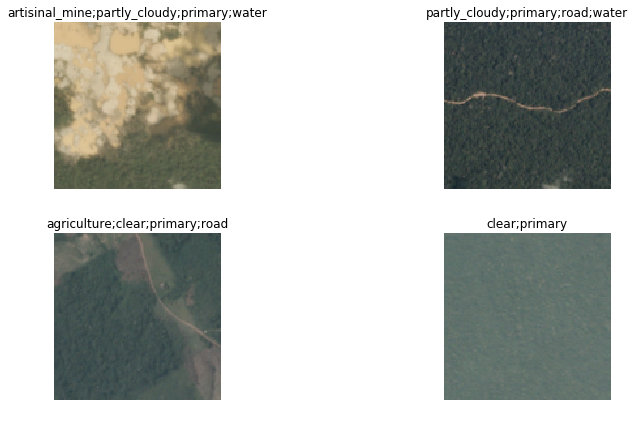

In [18]:
data.show_batch(rows=2, figsize=(12,6))

### metrics

`accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. 

![title](figures/FBeta.png)

### Resnet34

<pre>
from torchvision.models import ResNet,resnet18,resnet34,resnet50,resnet101,resnet152

def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model
</pre>

In [59]:
arch = models.resnet34

In [20]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)


<pre>
fastai.vision.learner.py

def create_cnn(data:DataBunch, arch:Callable, cut:Union[int,Callable]=None, pretrained:bool=True,
                lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                custom_head:Optional[nn.Module]=None, split_on:Optional[SplitFuncOrIdxList]=None,
                bn_final:bool=False, **kwargs:Any)->Learner:
    "Build convnet style learners."
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    nf = num_features_model(body) * 2
    head = custom_head or create_head(nf, data.c, lin_ftrs, ps=ps, bn_final=bn_final)
    model = nn.Sequential(body, head)
    learn = Learner(data, model, **kwargs)
    learn.split(ifnone(split_on,meta['split']))
    if pretrained: learn.freeze()
    apply_init(model[1], nn.init.kaiming_normal_)
    return learn
</pre>

<pre>
def cnn_config(arch):
    "Get the metadata associated with `arch`."
    torch.backends.cudnn.benchmark = True
    return model_meta.get(arch, _default_meta)
</pre>

In [ ]:
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


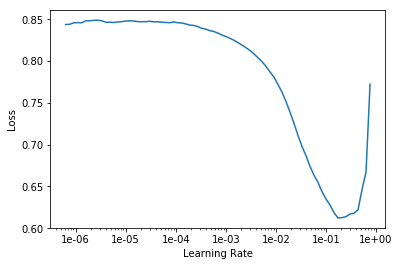

In [21]:
learn.lr_find()
learn.recorder.plot()

Then we can fit the head of our network.

In [22]:
lr = 1e-2

In [23]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.134157,0.111360,0.947913,0.905150
2,0.114524,0.100402,0.944650,0.910940
3,0.107260,0.097248,0.951553,0.911813
4,0.101208,0.091827,0.952788,0.920028
5,0.099078,0.090866,0.953595,0.921237


In [26]:
learn.save(f'{MODEL_NAME}_stage-1-rn34')

fine-tune the whole model:

In [27]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


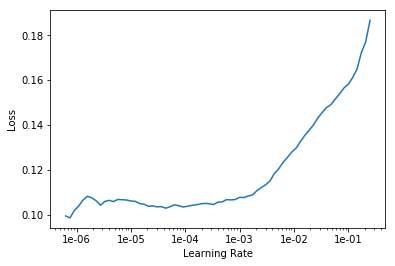

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(5, slice(1e-5, lr/10))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.100483,0.092215,0.952084,0.920743
2,0.097177,0.090699,0.953413,0.920433
3,0.093773,0.087346,0.956277,0.924430
4,0.088342,0.085180,0.957134,0.925187
5,0.083479,0.084723,0.957134,0.925996


In [30]:
learn.save(f'{MODEL_NAME}_stage-2-rn34')

### Transfer learning

See excellent notes here:

https://github.com/hiromis/notes/blob/master/Lesson3.md  Making the model better 50:30

*I trained quite a lot and I'm on the verge of overfitting then I'm basically creating a whole new dataset effectively﹣one where my images are twice the size on each axis right so four times bigger. So it's really a totally different data set as far as my convolutional neural networks concerned. So I got to lose all that overfitting. I get to start again. Let's keep our same learner but use a new data bunch where the data bunch is 256 by 256. That's why I actually stopped here before I created my data sets* (Jeremy Howard 2019 Lesson3)


In [31]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

Note we use the same transforms, load the datset, then freeze to train only final layers

In [32]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


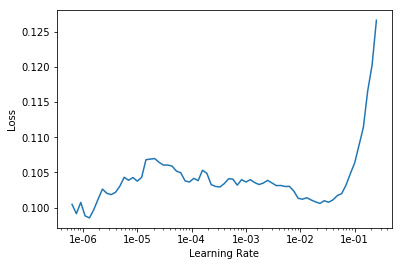

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
lr=1e-2/2

In [35]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.091240,0.087011,0.957236,0.923594
2,0.092775,0.085261,0.956974,0.924876
3,0.087377,0.085199,0.960034,0.924383
4,0.084465,0.082226,0.957839,0.928364
5,0.082061,0.082175,0.958486,0.927943


In [36]:
learn.save(f'{MODEL_NAME}_stage-1-256-rn34')

In [37]:
learn.unfreeze()

In [38]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.087681,0.084550,0.957759,0.926802
2,0.089255,0.085755,0.956066,0.926212
3,0.084019,0.083018,0.957316,0.928479
4,0.081592,0.081199,0.958653,0.928999
5,0.076929,0.081040,0.959009,0.929680


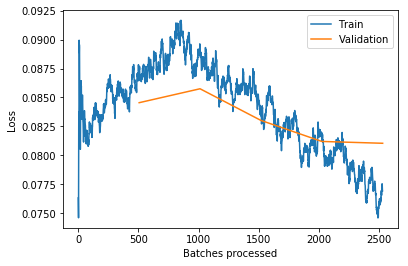

In [39]:
learn.recorder.plot_losses()

In [40]:
learn.save(f'{MODEL_NAME}_stage-2-256-rn34')

The following code saves the state of the learner so we can re-load at a later stage for testing 

In [42]:
learn.export(fname=f'{MODEL_NAME}_export.pkl')

### Without pre-training

Also without normalizing on imagenet stats

In [43]:
data = (src.transform(tfms, size=128)
        .databunch())

In [44]:
learn = create_cnn(data, arch, pretrained=False, metrics=[acc_02, f_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


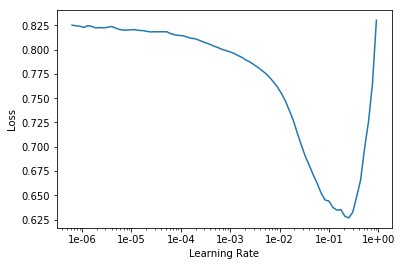

In [45]:
learn.lr_find()
learn.recorder.plot()

In [46]:
lr = 1e-2

In [47]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.178858,0.192199,0.885463,0.806592
2,0.158944,0.160979,0.923395,0.854619
3,0.145201,0.132530,0.927144,0.883558
4,0.130579,0.119861,0.932137,0.892533
5,0.118541,0.110587,0.938241,0.903488


Validation loss starts out higher than training loss - also loss is about 1.5 * loss with pre-training
and takes 4/5 epochs to get to where we were after 1 epoch using pre-trained model

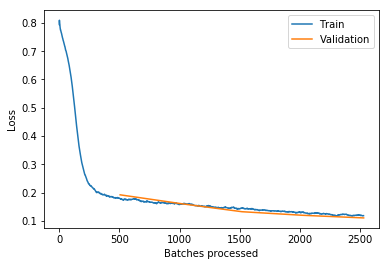

In [48]:
learn.recorder.plot_losses()

### Reload data

In [64]:
export_path=path

In [68]:
export_path

PosixPath('../data/planet')

In [67]:
#without
empty_data = data.load_empty(path=export_path, fname=f'{MODEL_NAME}_export.pkl')

TypeError: 'int' object is not subscriptable

In [60]:
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

In [65]:
learn.load(f'{MODEL_NAME}_stage-2-256-rn34')

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (32384 items)
[MultiCategory haze;primary, MultiCategory clear;primary, MultiCategory clear;primary, MultiCategory haze;primary;water, MultiCategory agriculture;clear;cultivation;primary;water]...
Path: ../data/planet
x: ImageItemList (32384 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../data/planet;

Valid: LabelList
y: MultiCategoryList (8095 items)
[MultiCategory clear;primary;road, MultiCategory clear;primary;water, MultiCategory clear;conventional_mine;habitation;primary;road;water, MultiCategory cloudy, MultiCategory agriculture;clear;cultivation;cultivation;habitation;primary;road;water]...
Path: ../data/planet
x: ImageItemList (8095 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../data/planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3